# Тестирование работы многослойного перцептрона


In [1]:
import sys
import os
current_dir = os.path.abspath('')
project_root = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, project_root)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
plt.rcParams["figure.figsize"] = (20,6)
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

## Анализ и подготовка данных

In [3]:
dfm=pd.read_csv('../data/2. Mushroom_dataset', delimiter = ",", names=['class-label','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat'])

In [4]:
dfm.describe(include = 'all') #Краткое описание данных

,class-label,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,...,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,EDIBLE,CONVEX,SCALY,BROWN,NO,NONE,FREE,CLOSE,BROAD,BUFF,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,WHITE,SEVERAL,WOODS
freq,4488,3796,3268,2320,5040,3808,8200,6824,5880,1728,...,5076,4744,4640,8416,8216,7768,3968,2424,4064,3160


У столбца veil-type только одно уникальное значение, нам он не нужен

In [5]:
dfm=dfm.drop(['veil-type'], axis=1)

Построим гистограммы распределения значений внутри признаков:

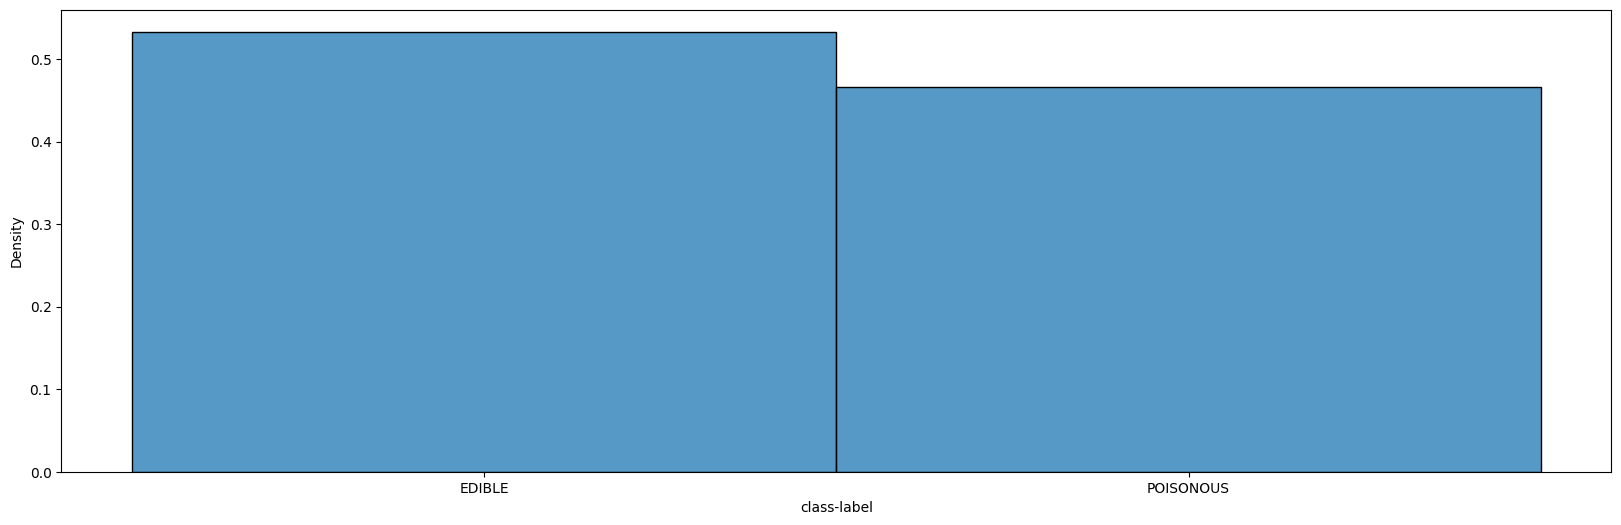

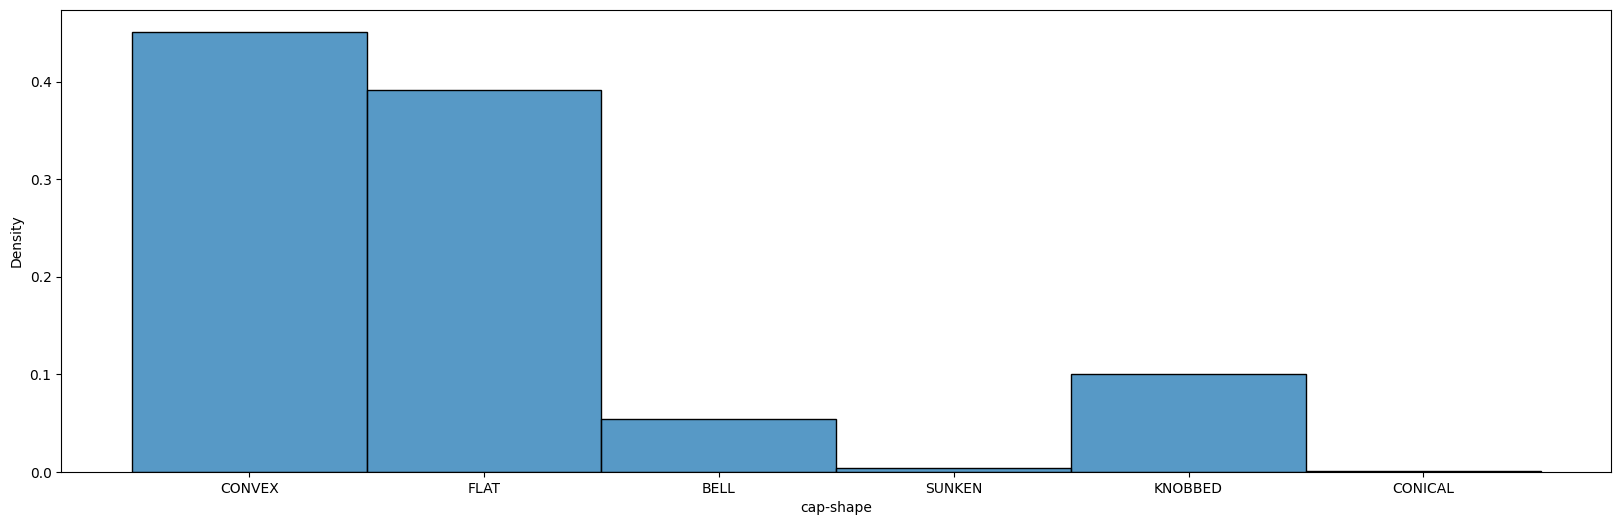

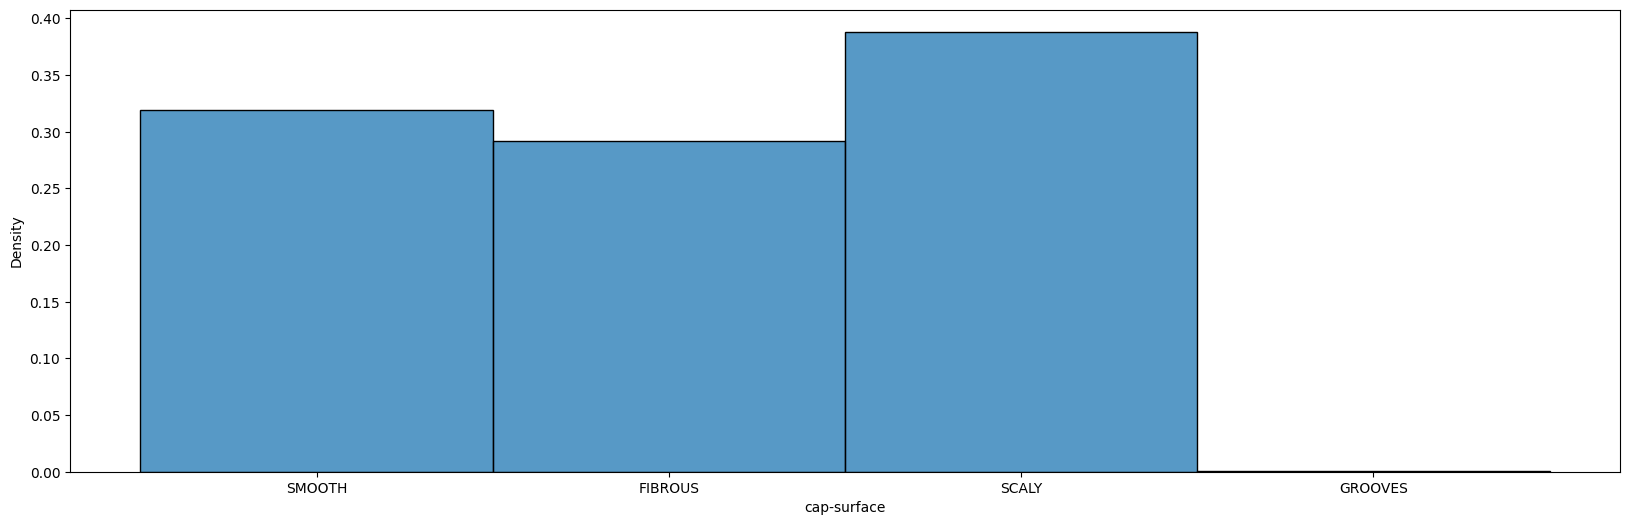

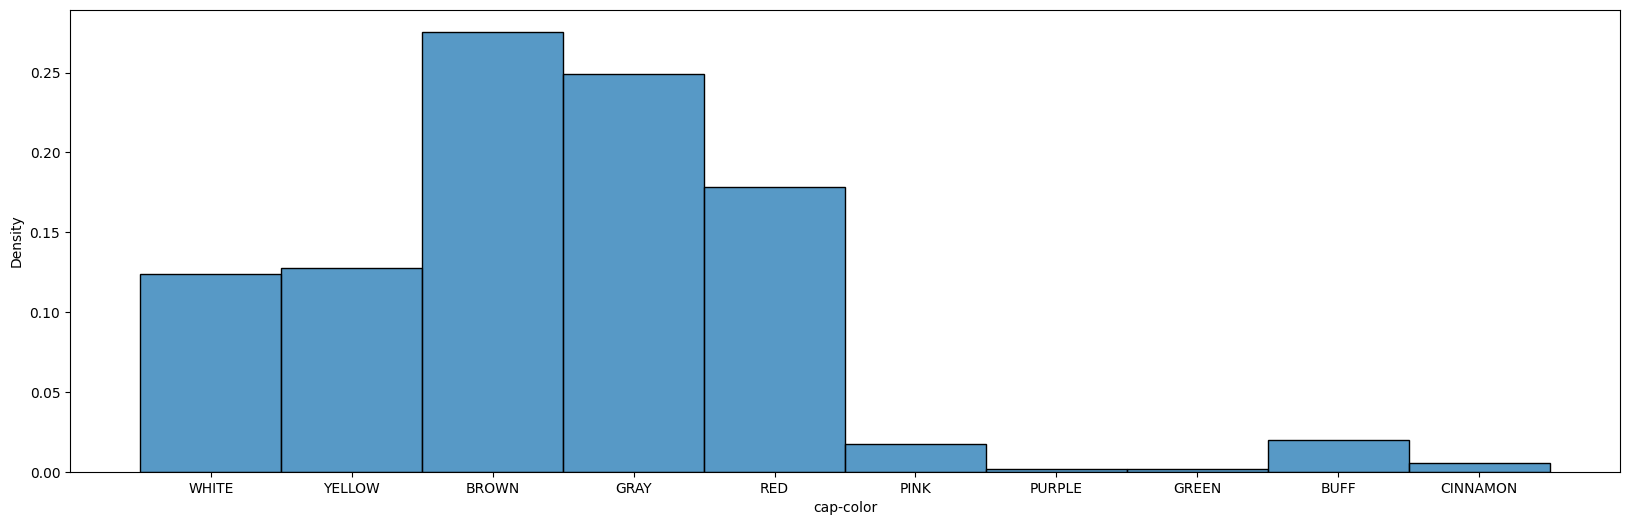

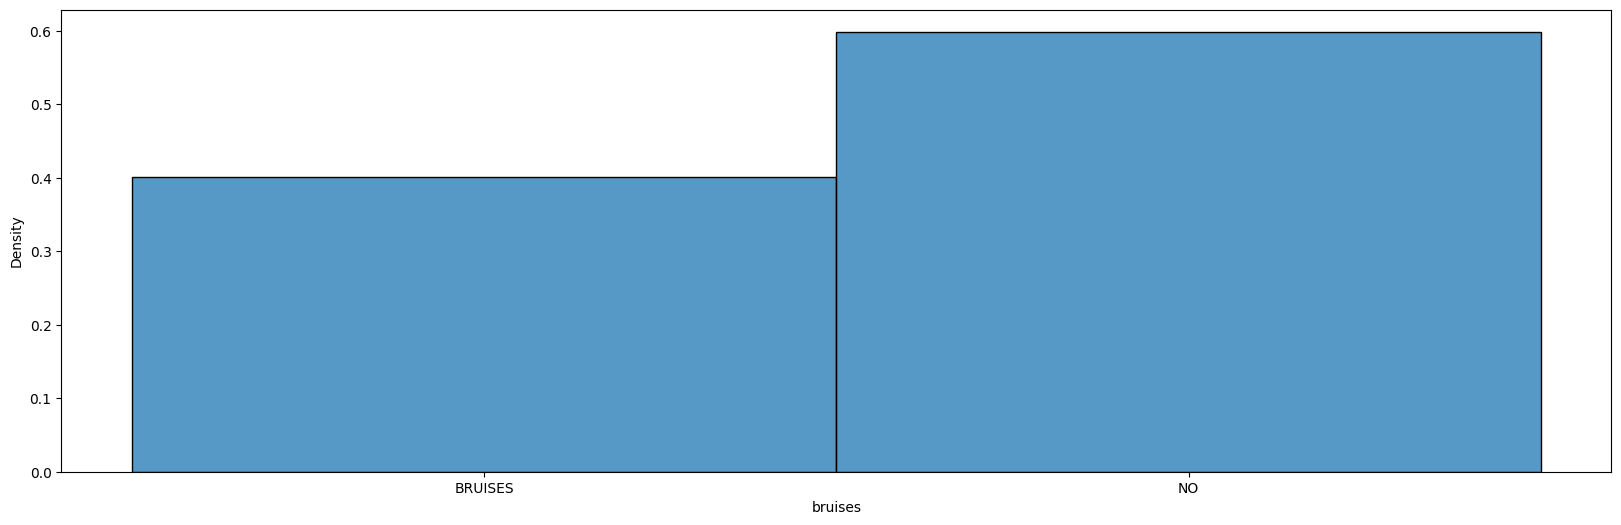

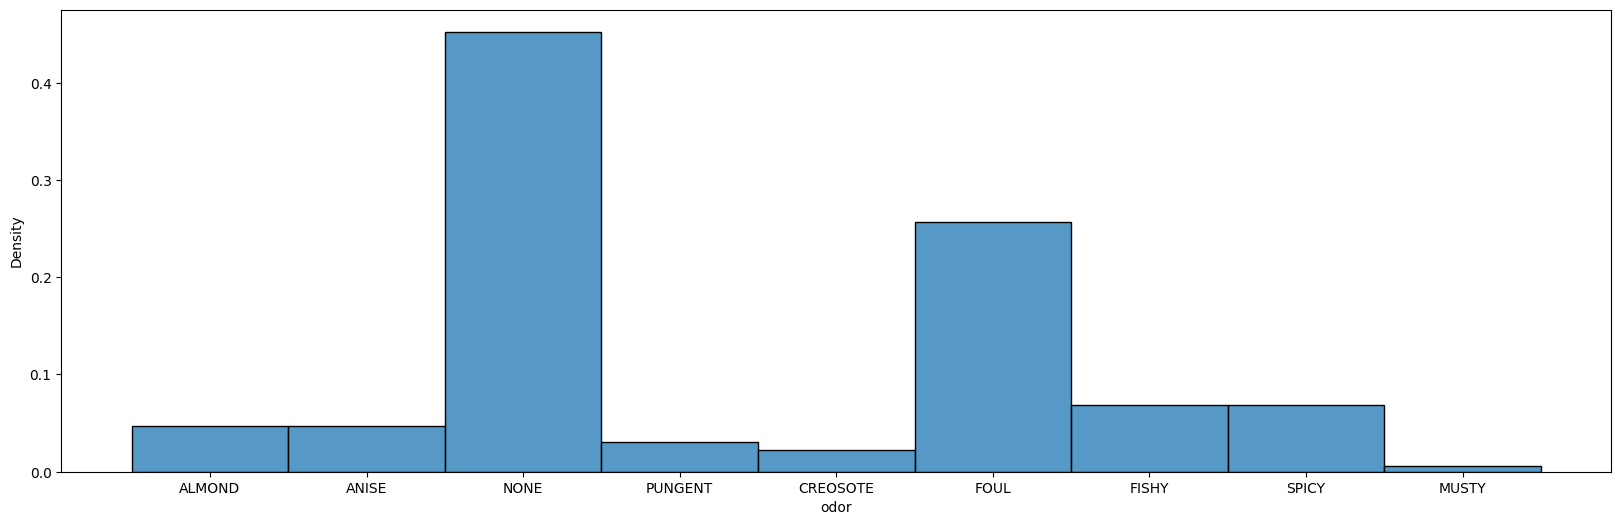

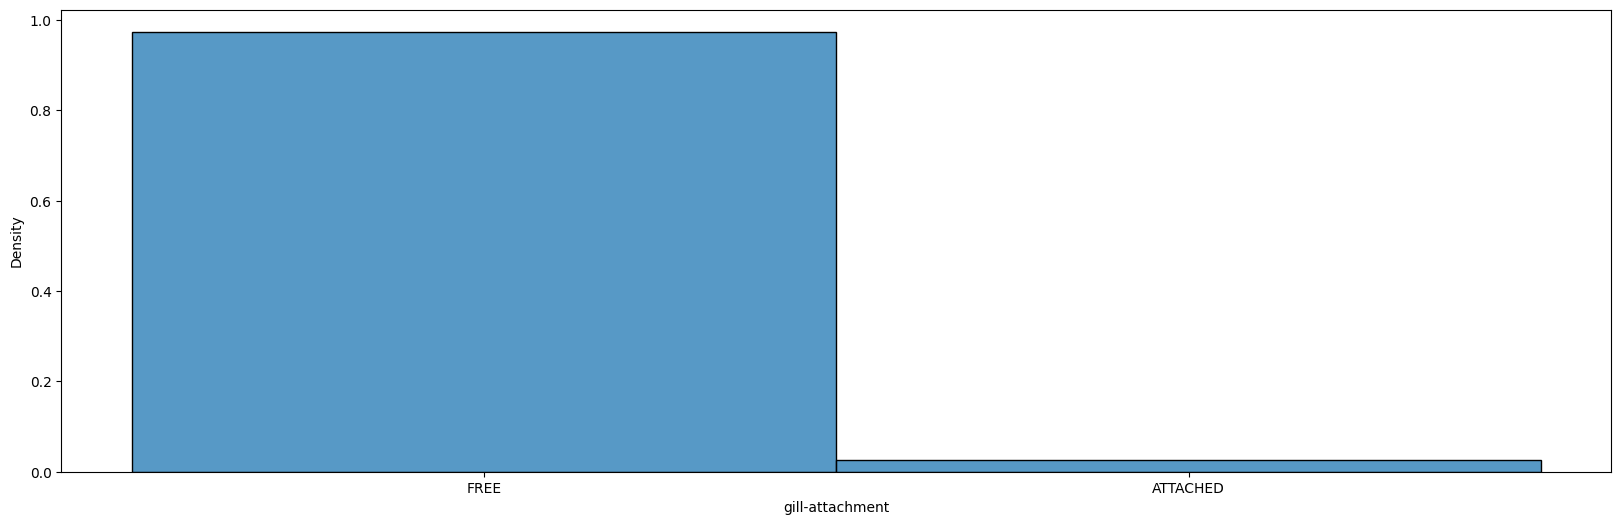

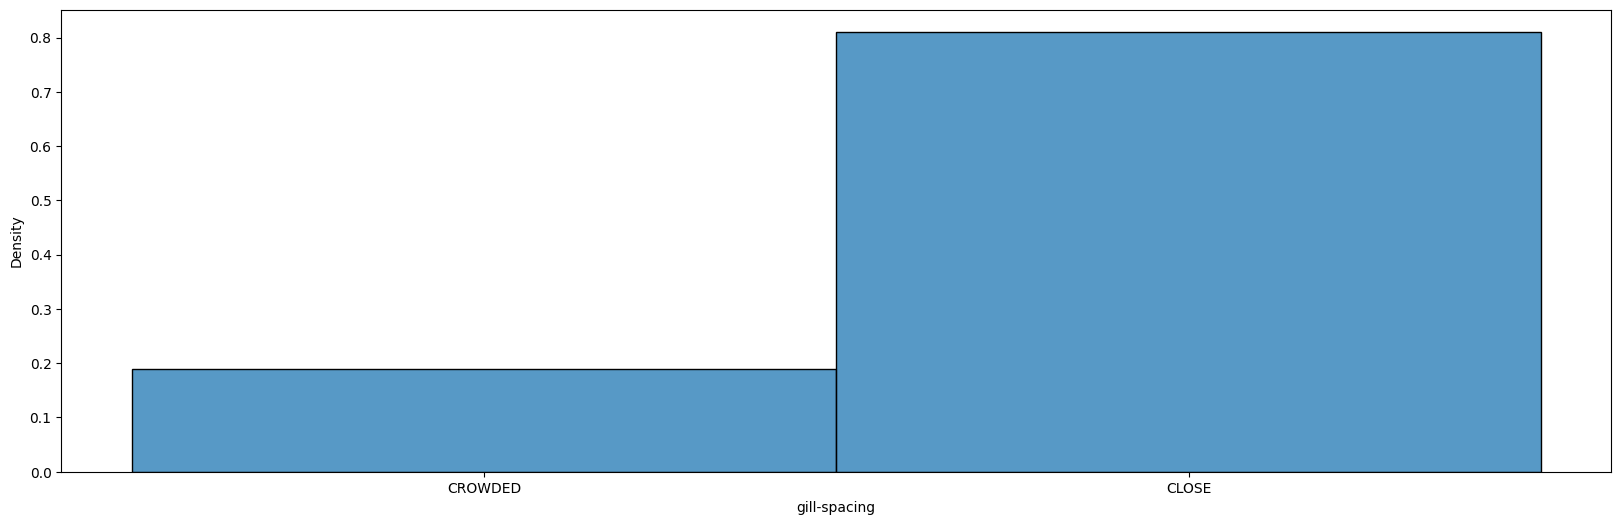

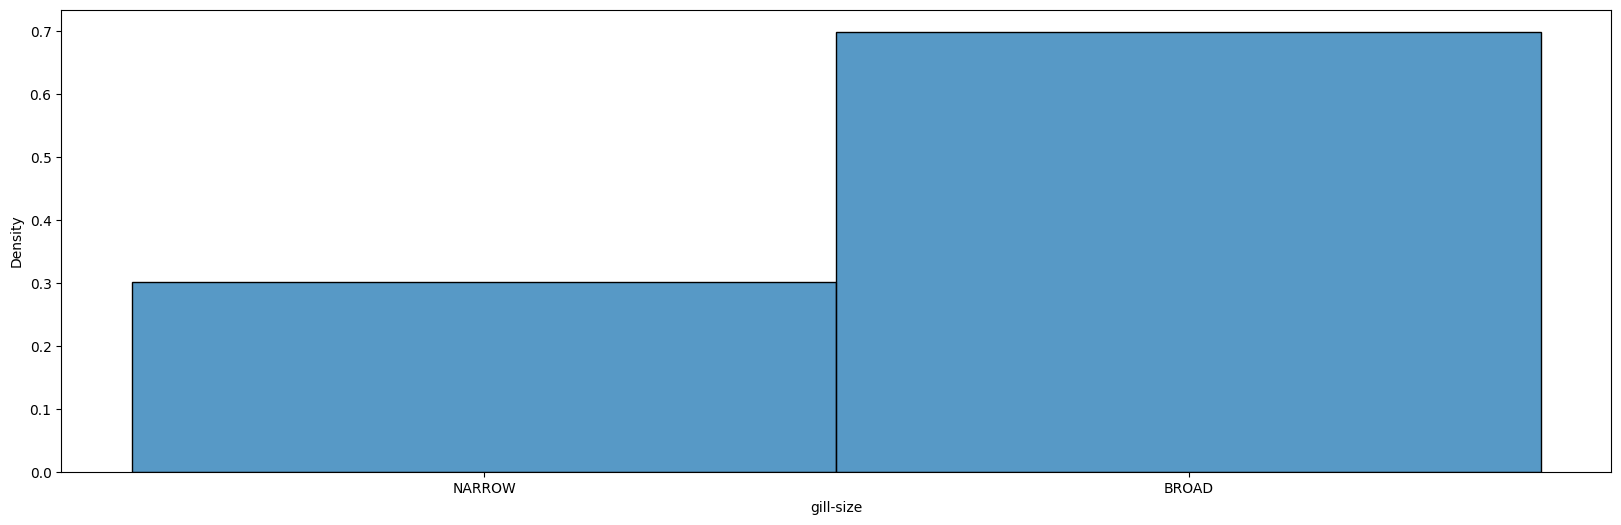

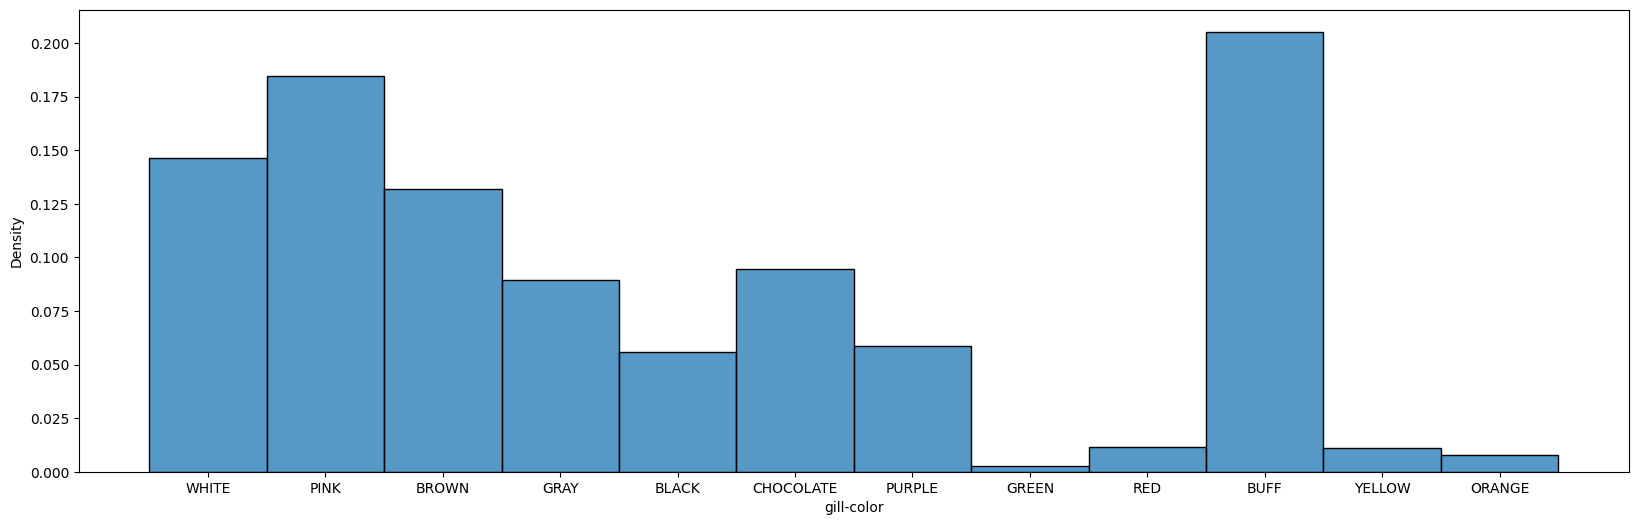

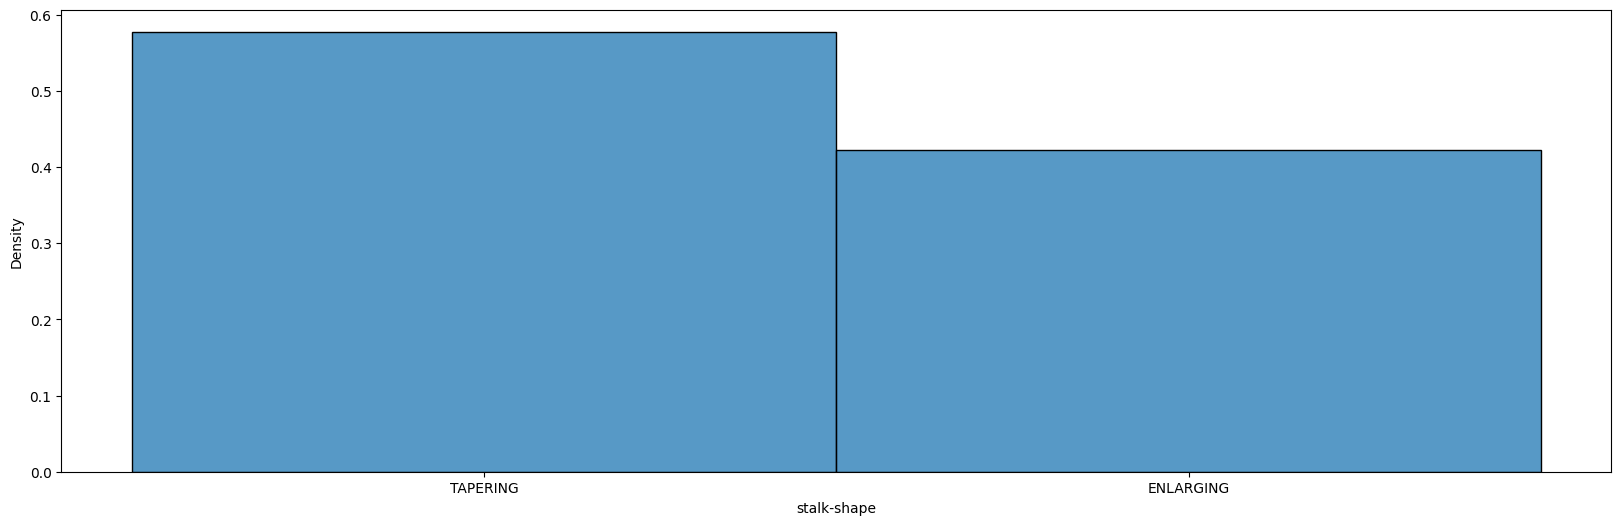

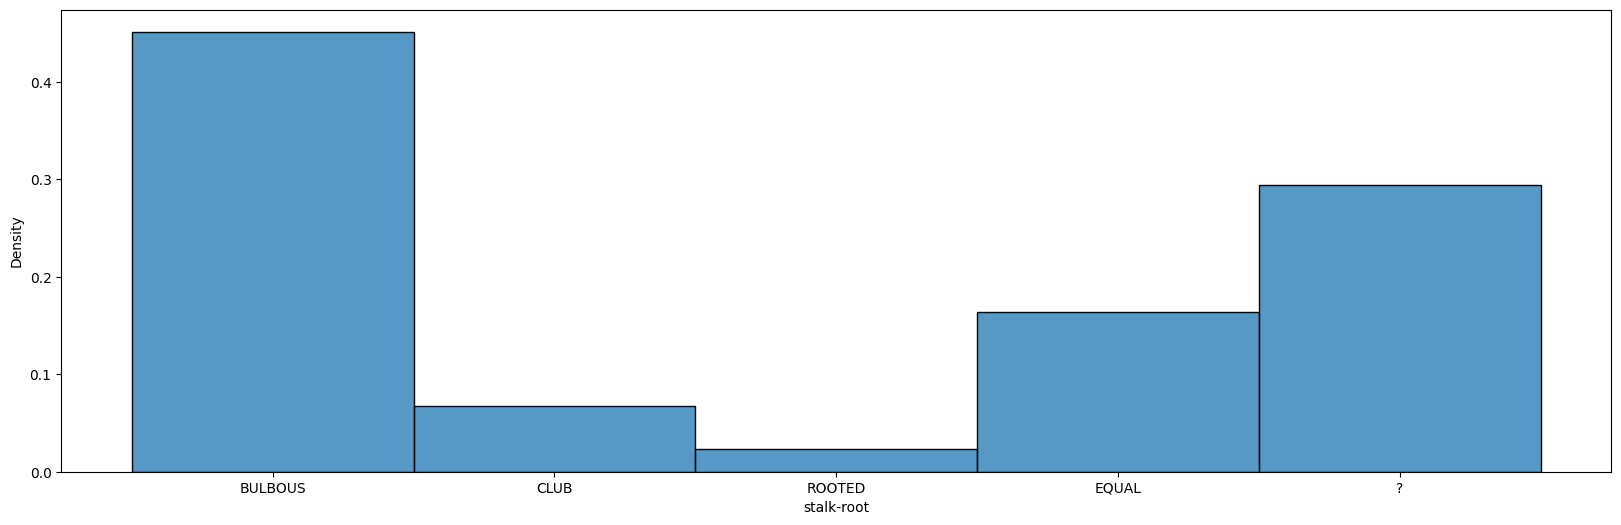

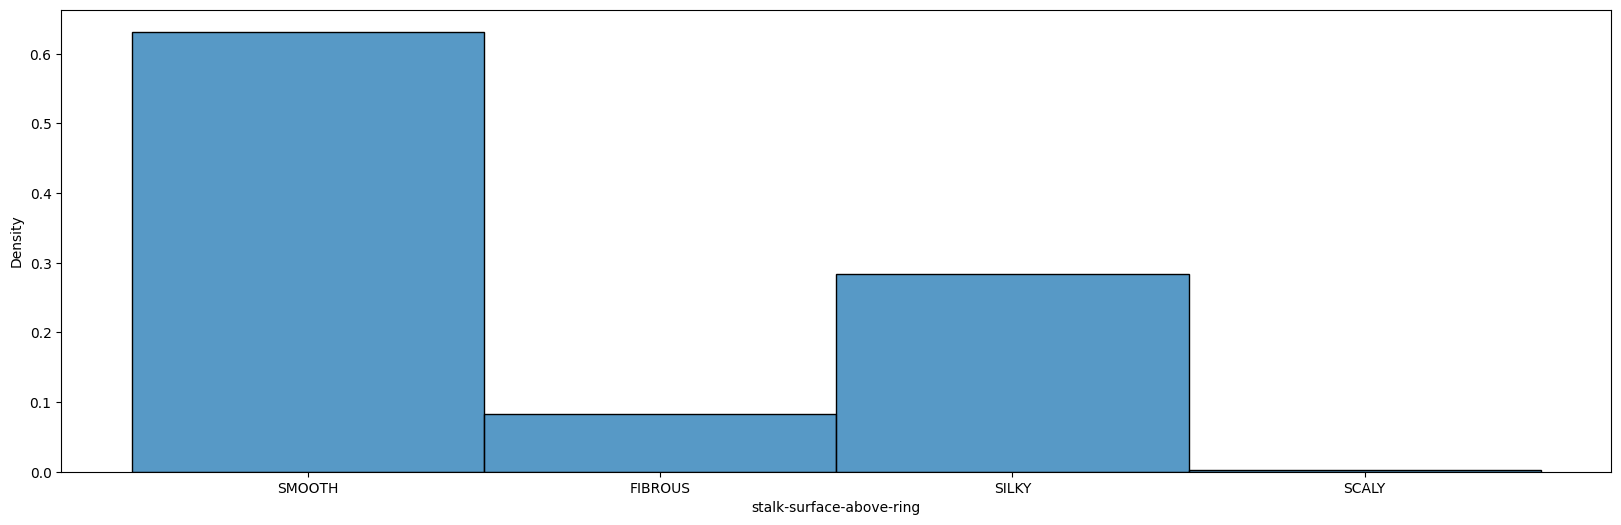

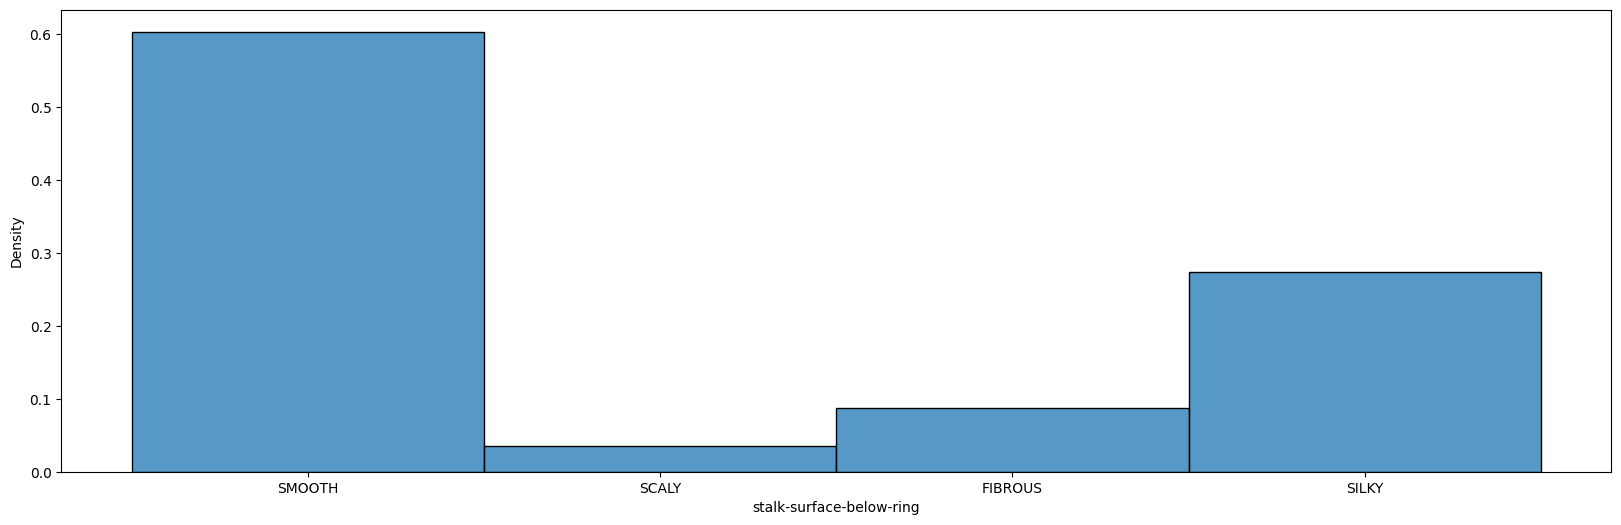

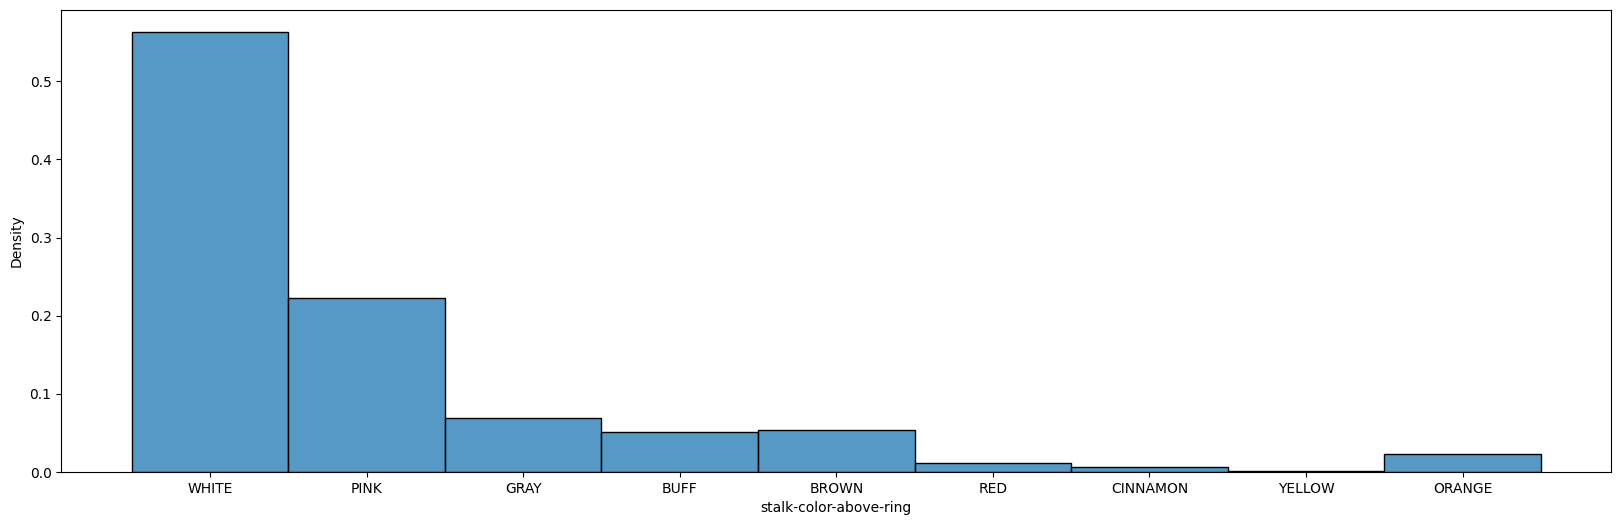

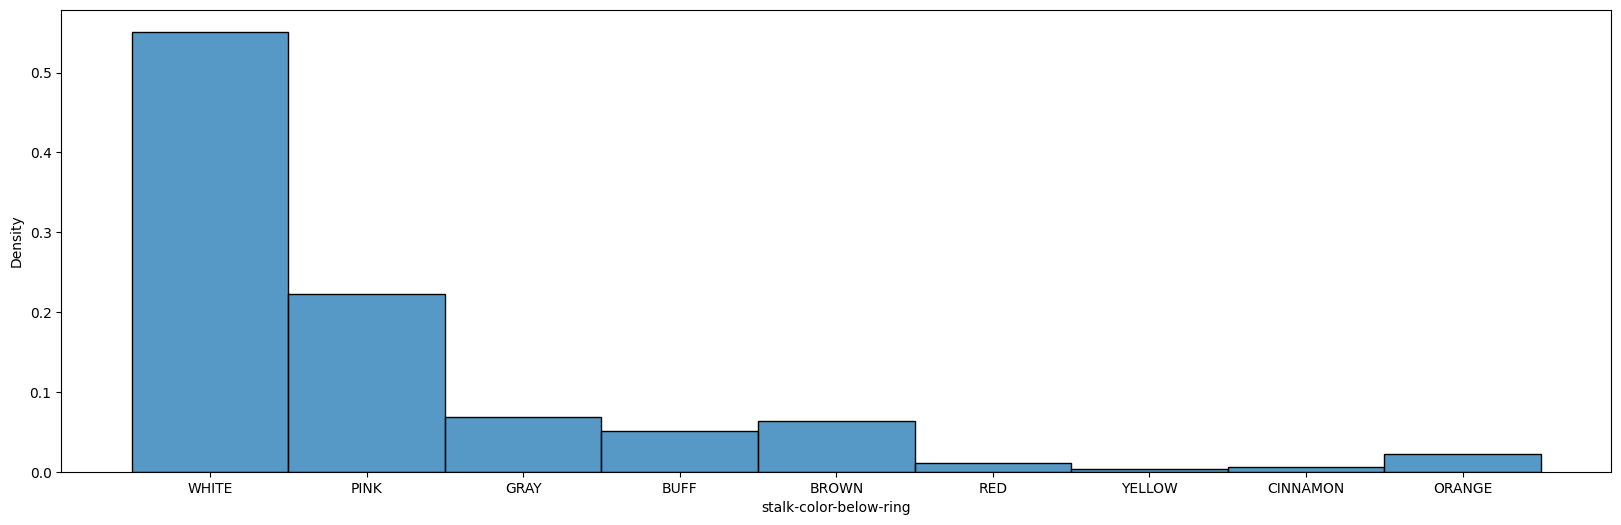

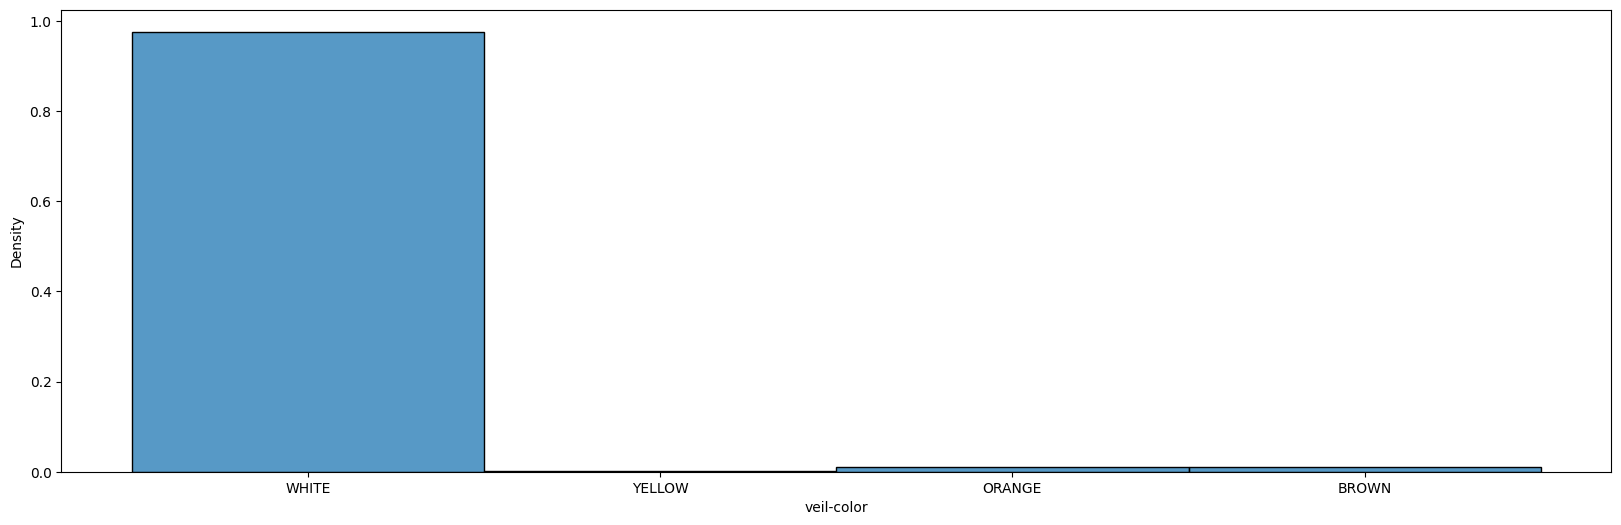

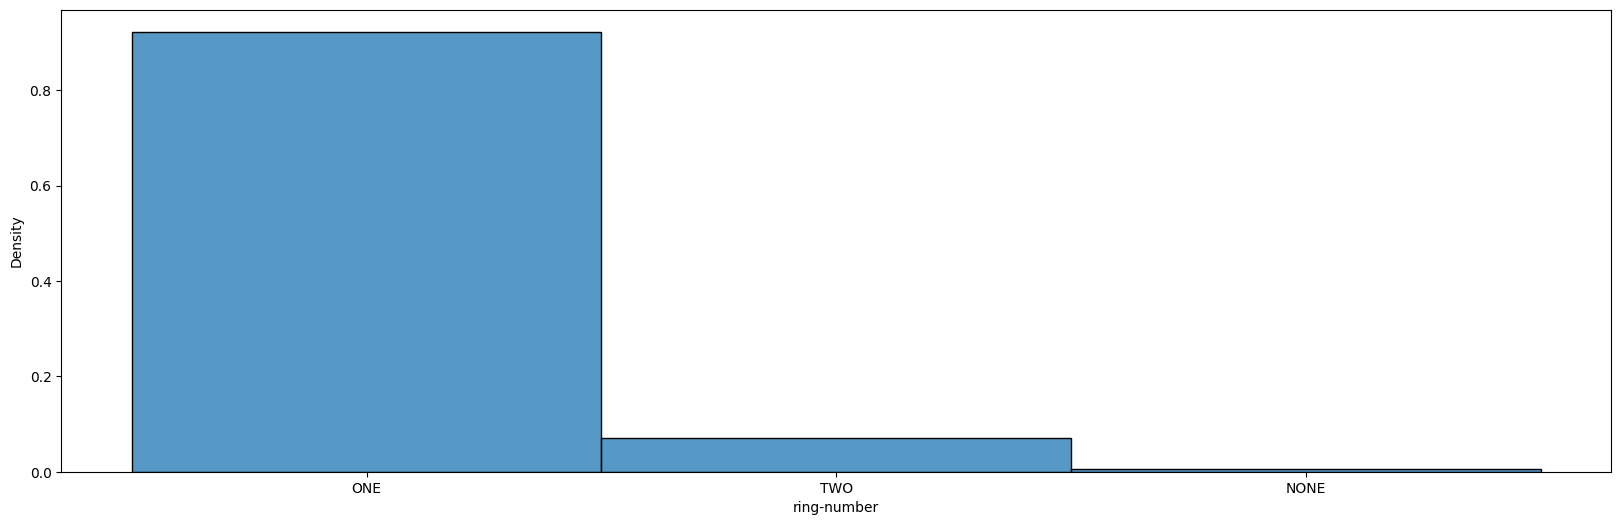

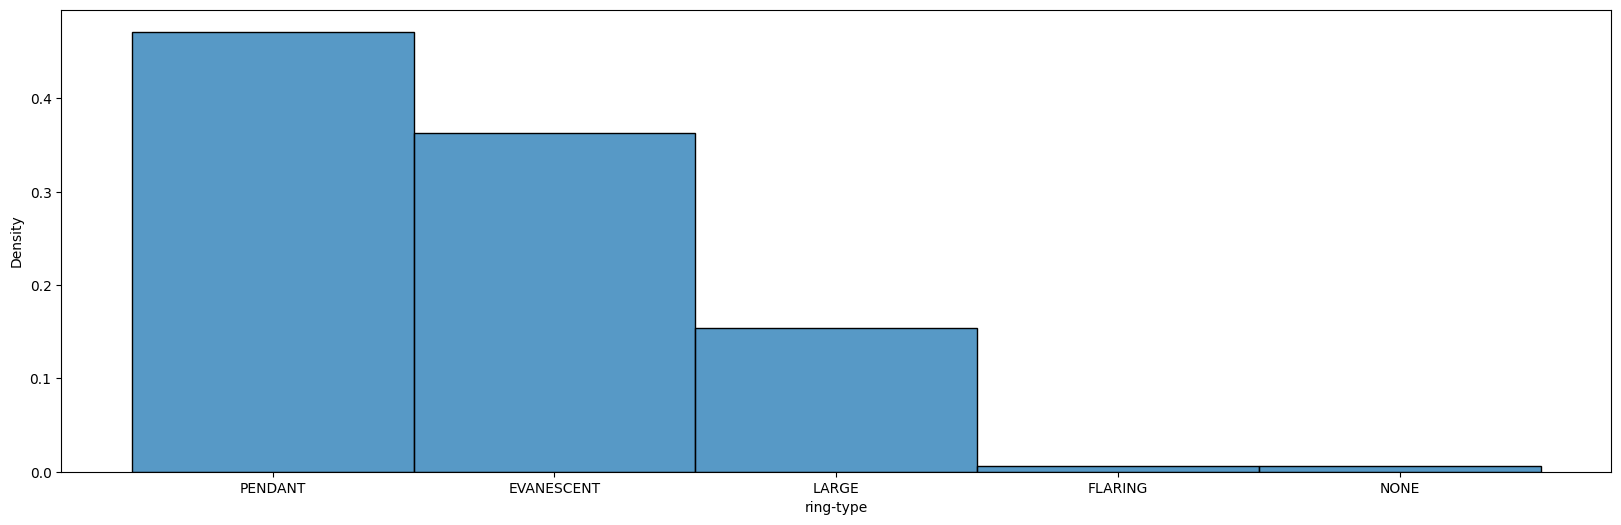

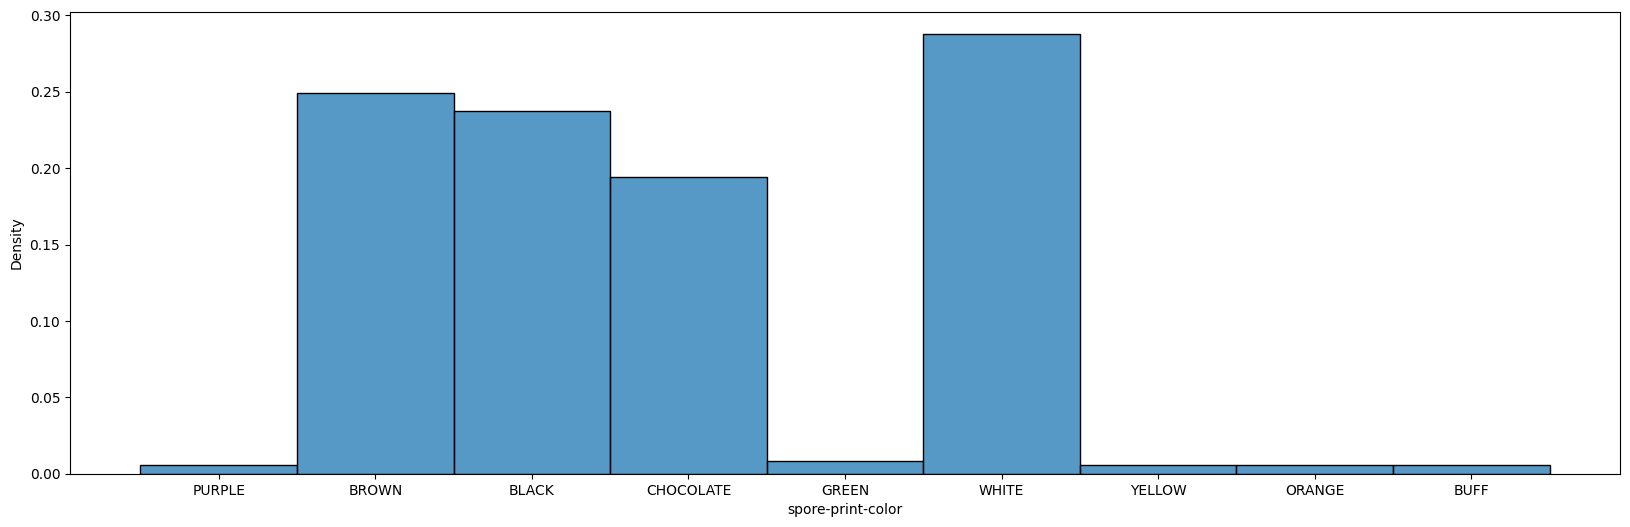

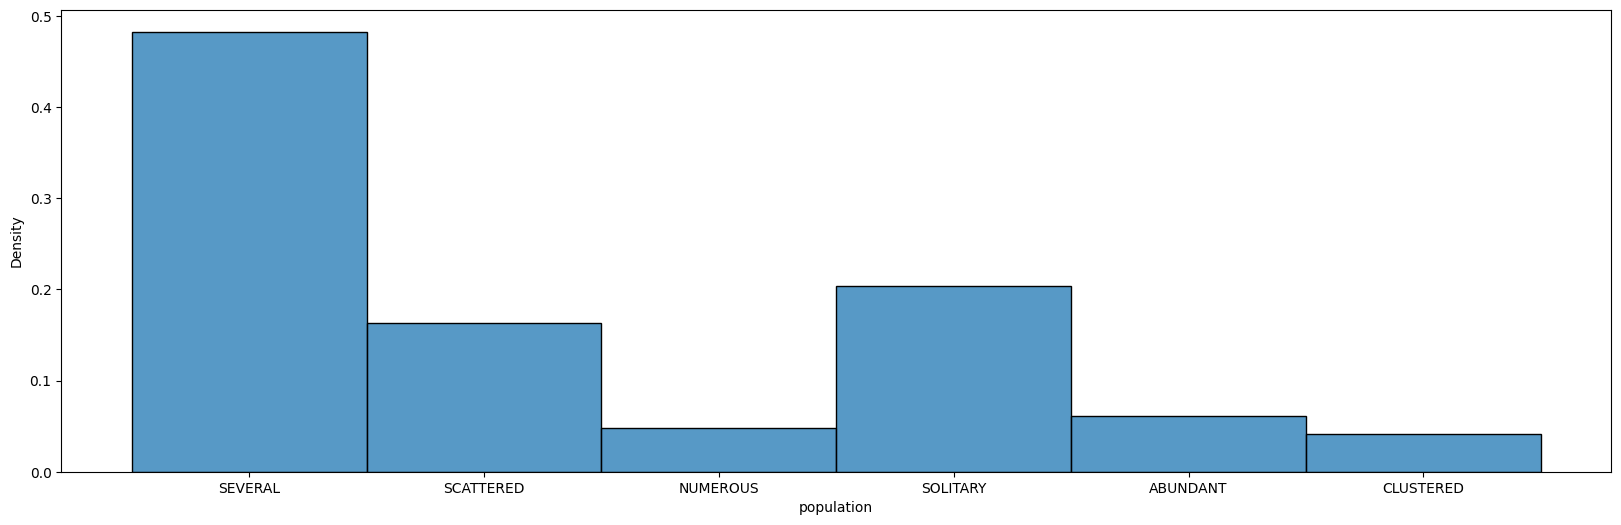

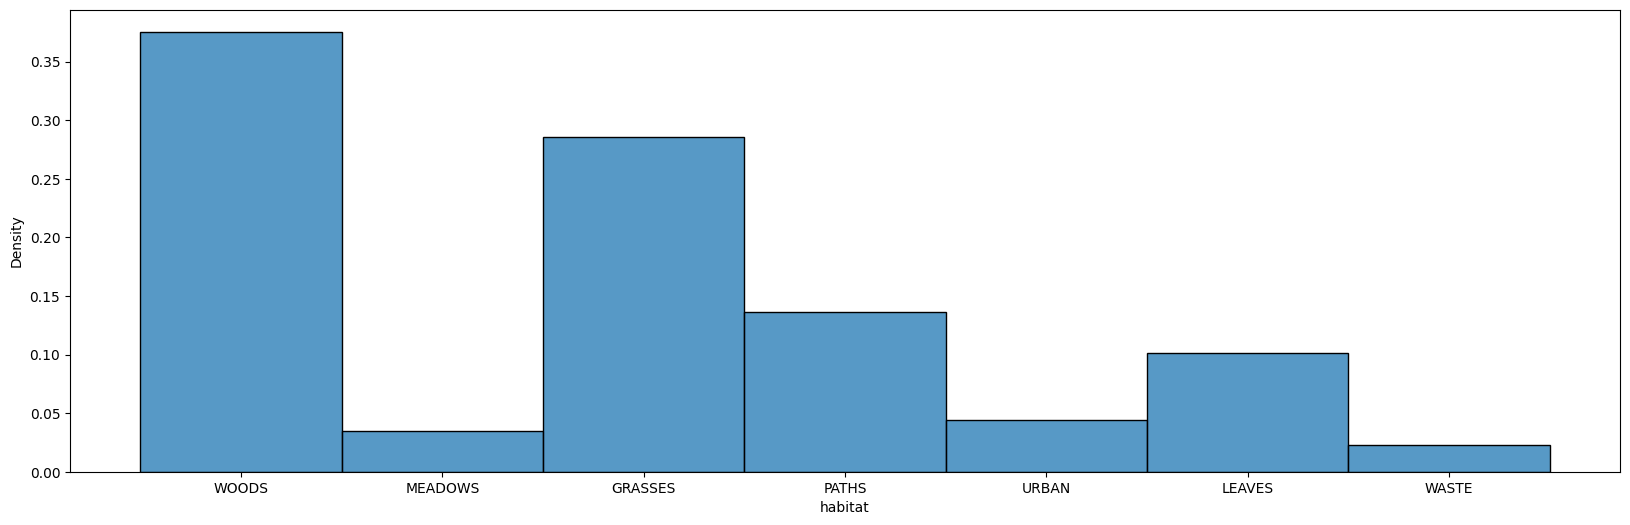

In [6]:
for i in dfm.columns:
    plt.figure(i)
    sns.histplot(dfm[i],stat="density")
    plt.show()

Применим случайный лес для оценки важности признаков:

In [7]:
le = preprocessing.LabelEncoder()
df=dfm.copy(deep=True)
for column_name in df.columns:
    df[column_name]=le.fit_transform(df[column_name])
Y=df.iloc[:, 0:1].values.ravel()
X=df.iloc[:, 1:22]

<Axes: >

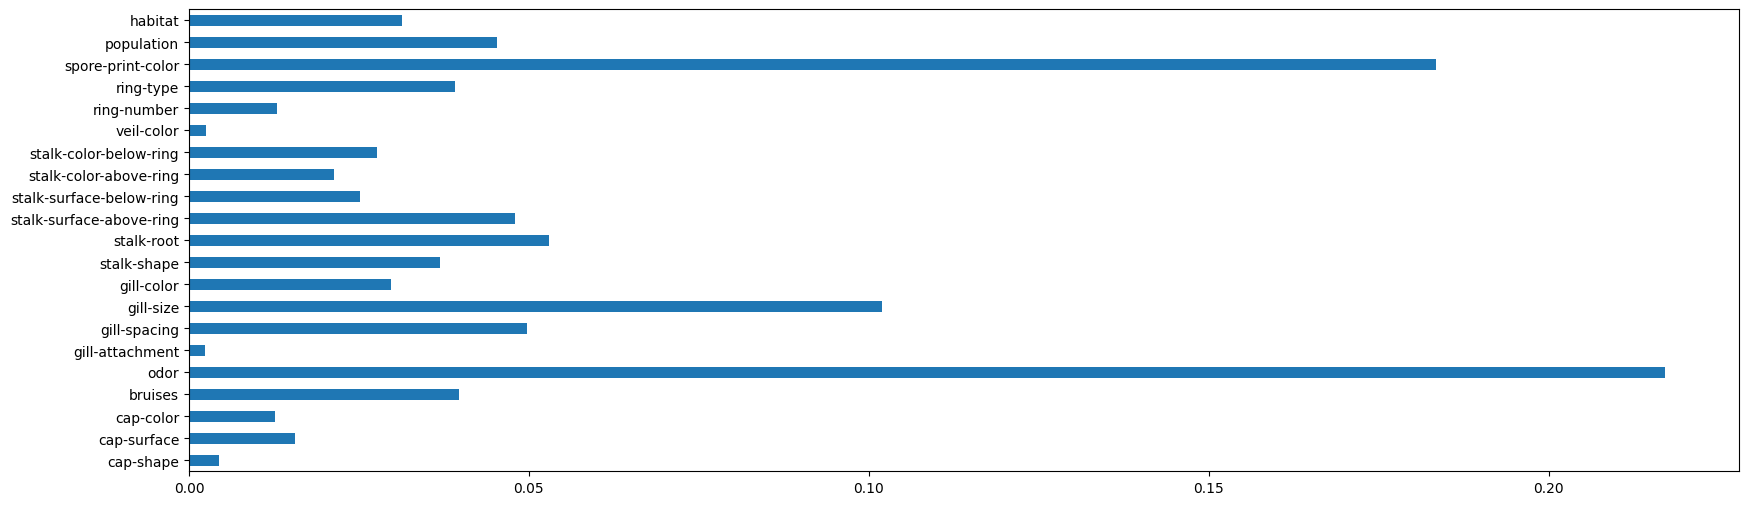

In [8]:
clf = RandomForestClassifier(criterion='entropy', random_state=0)
clf.fit(X, Y)

feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.plot(kind='barh')

Исходя из анализа гистограмм распределения числа признаков и их важностей преобразуем данные:

In [9]:
dfm['cap-shape'].mask(dfm['cap-shape'].isin(['BELL','SUNKEN','KNOBBED','CONICAL']), 'OTHER', inplace=True)
dfm['cap-color'].mask(dfm['cap-color'].isin(['PINK','PURPLE','GREEN','CINNAMON','BUFF']), 'OTHER', inplace=True)
dfm=dfm.drop(['gill-attachment'], axis=1)
dfm['gill-color'].mask(dfm['gill-color'].isin(['GREEN','RED','YELLOW','ORANGE']), 'OTHER', inplace=True)
dfm['stalk-color-above-ring'].mask(dfm['stalk-color-above-ring'].isin(['CINNAMON','RED','YELLOW','ORANGE']), 'OTHER', inplace=True)
dfm['stalk-color-below-ring'].mask(dfm['stalk-color-below-ring'].isin(['CINNAMON','RED','YELLOW','ORANGE']), 'OTHER', inplace=True)
dfm=dfm.drop(['veil-color'], axis=1)
dfm['ring-number'].mask(dfm['ring-number'].isin(['TWO','NONE']), 'NO_ONE', inplace=True)
dfm['cap-surface'].mask(dfm['cap-surface']=='GROOVES', 'SCALY', inplace=True)
dfm['stalk-surface-above-ring'].mask(dfm['stalk-surface-above-ring']=='SCALY', 'FIBROUS', inplace=True)
dfm['ring-type'].mask(dfm['ring-type'].isin(['FLARING','NONE']), 'OTHER', inplace=True)

Применим one-hot encoding к признакам и таргету:

In [10]:
onehotencoder = OneHotEncoder(sparse_output=False)
X = onehotencoder.fit_transform(dfm.loc[:, dfm.columns != 'class-label'])
dfm['class-label'].mask(dfm['class-label'] == 'EDIBLE', 1, inplace=True)
dfm['class-label'].mask(dfm['class-label'] == 'POISONOUS', 0, inplace=True)
Y=dfm['class-label'].to_numpy()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42) 

## Обучение и тестирование модели

In [13]:
from mlp.mlp import MLP

In [14]:
net_arch = (90, 150, 100, 60, 1)#Наилучший из протестированных вариантов
mlp = MLP(net_arch)
epochs = 200
epoch_losses = mlp.train(X_train, y_train, epochs=epochs)

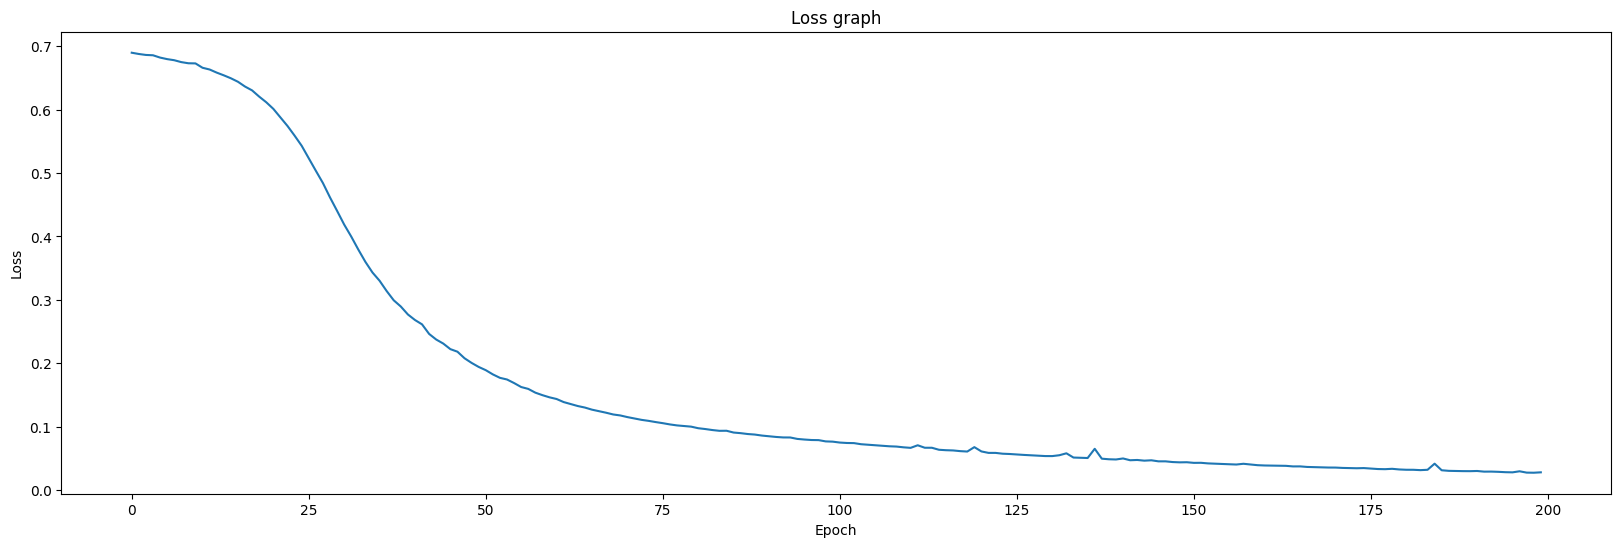

In [15]:
plt.plot(epoch_losses)
plt.title('Loss graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [16]:
from utils.metrics import accuracy, precision, recall, f_score, build_roc

In [17]:
y_pred=mlp.predict_classes(X_test)
print(f"Accuracy: {accuracy(y_pred,y_test)}\nPrecision: {precision(y_pred,y_test)}\nRecall: {recall(y_pred,y_test)}\nF-score: {f_score(y_pred,y_test)}")

Accuracy: 0.9932673267326733
Precision: 0.9890350877192983
Recall: 0.9985239852398524
F-score: 0.9937568857877341


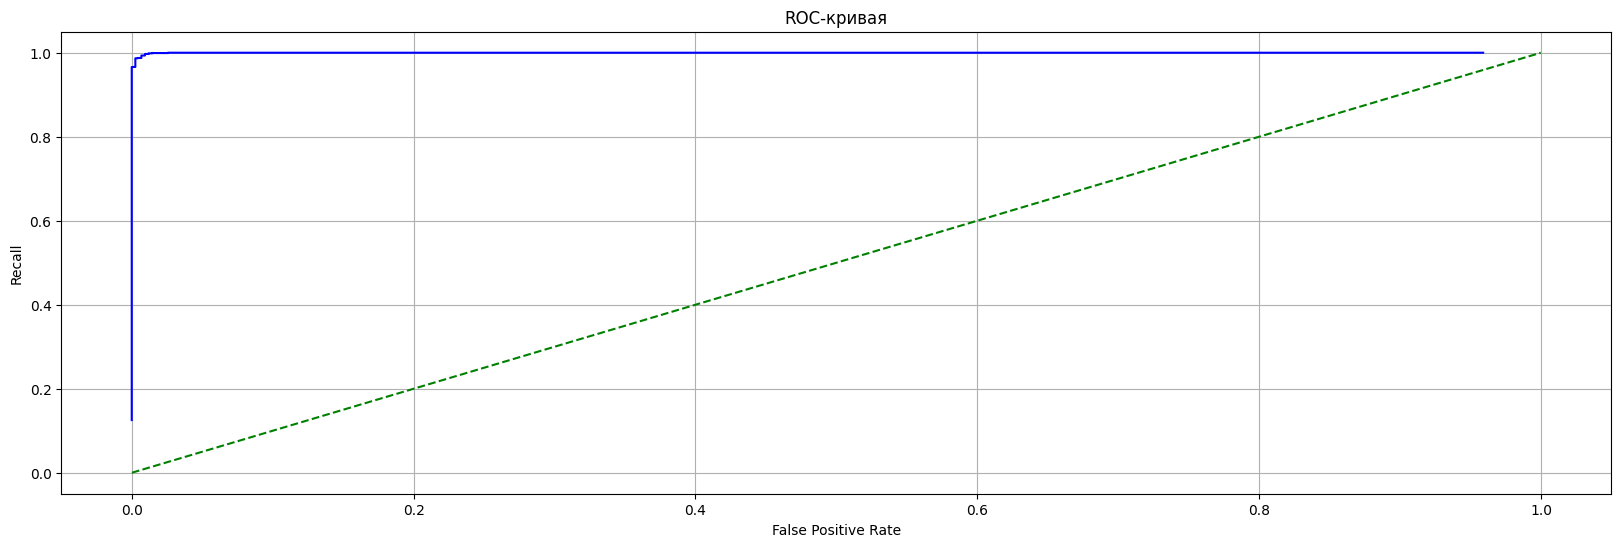

In [19]:
build_roc(mlp, X_test, y_test, n_tresholds=10000)